In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import glob
import numpy as np
import astropy.io.fits as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood
from scipy.optimize import curve_fit
#from sklearn.mixture import GaussianMixturet
from sklearn import mixture
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
obsid=4103010246
fname="/Volumes/WD_BLACK/Data/GRS1915p105/NICER/data_2021/results4/%s/ni%s_0mpu7_cl.evt"%(obsid,obsid)
#fname="/Volumes/5T_disk1/Data/GRS1915p105/NICER/results_filter/%s/ni%s_0mpu7_cl.evt"%(obsid,obsid)
events = EventList.read(fname, "hea")

/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")


In [17]:
lc = events.to_lc(1)

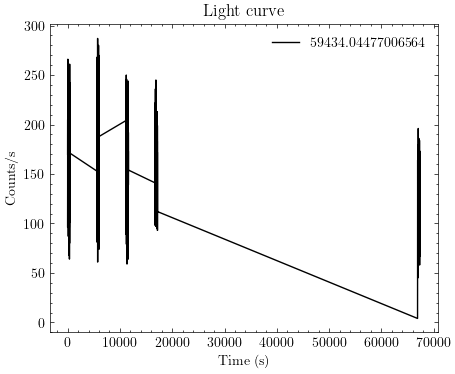

In [18]:
plt.figure(figsize=(5, 4))
mk = lc.countrate > 0
MJDOBS=events.mjdref+fits.open(fname)[0].header['tstart']/86400.
plt.plot(lc.time[mk]-lc.time[0], lc.countrate[mk],'-k',label='%s'%MJDOBS)
#bad_time_intervals = list(zip(lc.gti[:-1, 1], lc.gti[1:, 0]))
#time_intervals = list(lc.gti)
#for b in time_intervals:
#    plt.axvspan(b[0], b[1], color='r', alpha=0.3, zorder=10)
plt.title("Light curve")
plt.xlabel(f"Time (s)")
plt.ylabel(f"Counts/s")
plt.legend()
#plt.xlim(35000,40000)
#plt.savefig("/Volumes/5T_disk1/Data/GRS1915p105/NICER/results/%s/%s.pdf"%(obsid,obsid))

In [19]:
events = EventList.read(fname, "hea")
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size=128
# Sampling time of the light curve: 1ms, this will give a Nyquist
# frequency of 0.5 / dt = 500 Hz.
dt=0.01
# Fractional rms normalization
norm="leahy"

energy_band = [1,8]
events = events.filter_energy_range(energy_band)

pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt,
    norm=norm, use_common_mean=True,gti=lc.gti)

# Calculate the mean count rate
ctrate = get_average_ctrate(events.time, events.gti, segment_size)
# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")
15it [00:00, 3798.50it/s]


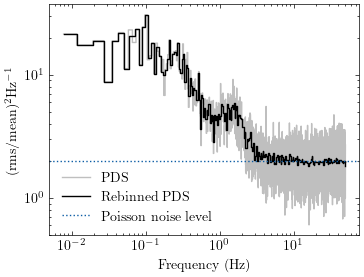

In [20]:
plt.figure(figsize=(4, 3))
plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
#plt.axvline(x=0.13)
#plt.axvline(x=0.22)
#plt.ylim(1,60)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$");
plt.legend()

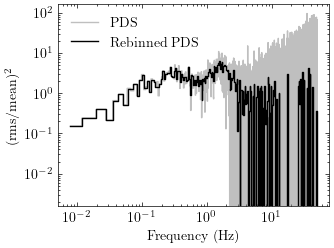

In [21]:
plt.figure()
plt.plot(pds.freq, (pds.power - noise) * pds.freq, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, (pds_reb.power - noise) * pds_reb.freq, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");
plt.legend();

In [22]:
freq_max = pds_reb.freq[np.argmax(pds_reb.power)]
freq_max

0.1015625

In [23]:
lc = events.to_lc(10)
new_gti = create_gti_from_condition(lc.time, lc.countrate > 1, safe_interval=32)
print(new_gti)
LC = lc.split_by_gti(gti=new_gti)
#plt.plot(lc.time,lc.countrate)
intervals1=[0]
n=0
while n < len(LC)-1:
    interval1=LC[n+1].time[0]-LC[n].time[-1]
    intervals1.append(interval1)
    n+=1
print(intervals1)
intervals_new=[0]
i=1
while i < len(intervals1):
    #print(intervals1[:i])
    inter=sum(intervals1[:i+1])
    intervals_new.append(inter)
    i+=1
print(intervals_new)

[[2.39850338e+08 2.39850744e+08]
 [2.39855918e+08 2.39856324e+08]
 [2.39861498e+08 2.39861904e+08]
 [2.39867068e+08 2.39867464e+08]
 [2.39917248e+08 2.39917634e+08]]
[0, 5200.0, 5200.0, 5190.0, 49810.0]
[0, 5200.0, 10400.0, 15590.0, 65400.0]


In [24]:
import stingray
dt=0.01
lc = events.to_lc(dt)
LC = lc.split_by_gti(gti=new_gti)
DPS=[]
for i in LC:
    try:
        dps = stingray.DynamicalPowerspectrum(i, segment_size=30, norm='leahy')
        #dps.rebin_frequency(df_new=0.1, method="average")
        DPS.append(dps)
    except:
        pass

13it [00:00, 10850.94it/s]
13it [00:00, 2721.40it/s]
13it [00:00, 6040.99it/s]
13it [00:00, 2826.64it/s]
13it [00:00, 7839.82it/s]
13it [00:00, 2692.64it/s]
13it [00:00, 8216.69it/s]
13it [00:00, 3481.64it/s]
12it [00:00, 8146.92it/s]
12it [00:00, 2981.20it/s]


[0, 5175.0, 5175.0, 5165.0, 49785.0] [0, 5220.0, 5220.0, 5210.0, 49820.0]
[0, 5175.0, 10350.0, 15515.0, 65300.0] [0, 5220.0, 10440.0, 15650.0, 65470.0]


(0.0, 1770.0)

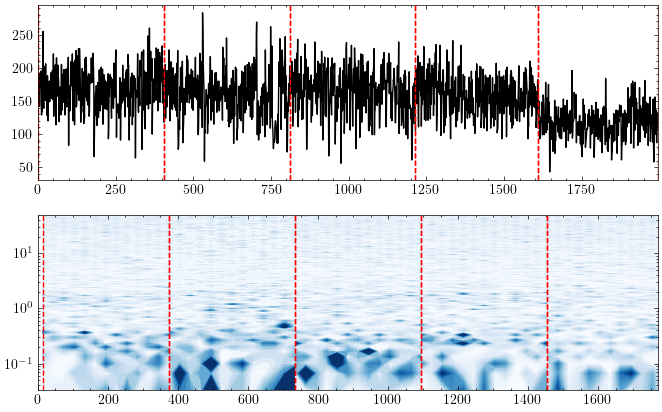

In [25]:
fig, axs = plt.subplots(2,1,figsize=(8, 5))
lc1 = events.to_lc(1)
LC1 = lc1.split_by_gti(gti=new_gti)
intervals1=[0]
intervals2=[0]
n=0
while n < len(DPS)-1:
    interval1=LC1[n+1].time[0]-LC1[n].time[-1]
    intervals1.append(interval1)    
    interval2=DPS[n+1].time[0]-DPS[n].time[-1]
    intervals2.append(interval2)
    n+=1
print(intervals1,intervals2)
intervals_new1=[0]
i=1
while i < len(intervals1):
    #print(intervals1[:i])
    inter=sum(intervals1[:i+1])
    intervals_new1.append(inter)
    i+=1
#print(intervals_new1)
intervals_new2=[0]
i=1
while i < len(intervals2):
    #print(intervals1[:i])
    inter=sum(intervals2[:i+1])
    intervals_new2.append(inter)
    i+=1
#print(intervals_new2)
intervals1,intervals2=intervals_new1,intervals_new2
print(intervals1,intervals2)
#intervals1,intervals2=[0,0],[0,0]
i=0
while i < len(DPS):
    #print(len(DPS))
    #print(i)
    axs[0].plot(LC1[i].time-LC1[0].time[0]-intervals1[i],LC1[i].countrate,'-k')
    #axs[0].axhline(y=161,ls='--',color='red')
    axs[0].axvline(x=LC1[i].time[0]-LC1[0].time[0]-intervals1[i],ls='--',color='red')
    axs[0].axvline(x=LC1[i].time[-1]-LC1[0].time[0]-intervals1[i],ls='--',color='red')
    #print(DPS[i])
    xx, yy = np.meshgrid(DPS[i].time-LC1[0].time[0]-intervals2[i],DPS[i].freq)
    axs[1].contourf(xx,yy,DPS[i].dyn_ps-2,50,cmap='Blues',vmin=0.001, vmax=50)
    axs[1].axvline(x=DPS[i].time[0]-LC1[0].time[0]-intervals2[i],ls='--',color='red')
    axs[1].axvline(x=DPS[i].time[-1]-LC1[0].time[0]-intervals2[i],ls='--',color='red')
    #axs[1].imshow(i.dyn_ps, origin="lower", aspect="auto", vmin=1.0, vmax=15.0, interpolation="none")
    i+=1
plt.yscale('log')    
axs[0].set_xlim(0,max(LC1[-1].time-LC1[0].time[0]-intervals1[-1]))
axs[1].set_xlim(0,max(DPS[-1].time-DPS[0].time[0]-intervals2[-1]))
#axs[1].set_ylim(0.1,0.4)
#axs[1].axhline(y=freq_max,ls='--',color='red',label="QPO=%0.4f Hz"%freq_max)
#plt.legend()

In [26]:
new_gti

array([[2.39850338e+08, 2.39850744e+08],
       [2.39855918e+08, 2.39856324e+08],
       [2.39861498e+08, 2.39861904e+08],
       [2.39867068e+08, 2.39867464e+08],
       [2.39917248e+08, 2.39917634e+08]], dtype=float64)

In [27]:
2.39220064e+08,2.39220064e+08+220

(239220064.0, 239220284.0)

In [28]:
2.39220064e+08+220+150,2.39220860e+08-150

(239220434.0, 239220710.0)